In [387]:
# import of necessary files from other folders

import os
import sys

path = os.path.abspath('')
base_path = path.split('/microbial_ecology_in_space')[0]
module_path = f'{base_path}/microbial_ecology_in_space/models/shared'
module_path_1 = f'{base_path}/microbial_ecology_in_space/models/well_mixed'

# Add the directory to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path_1 not in sys.path:
    sys.path.append(module_path_1)

# libraries imports

import importlib
import numpy as np
import tempfile
import matplotlib.pyplot as plt

from IPython.display import Image, display
from PIL import Image
from scipy.integrate import solve_ivp

import visualize
import definitions
import well_mixed

importlib.reload(definitions)
importlib.reload(well_mixed)
importlib.reload(visualize)

<module 'visualize' from '/Users/federicasibilla/Documenti/Tesi/microbial_ecology_in_space/models/shared/visualize.py'>

# Consumer-Resource to Lotka-Volterra mapping

This notebook is intended as an exercise and a demonstration of how a consumer-resource model can be mapped to a LV one. It is then used specifically for the case of the famous two auxotrophs. 

## Theoretical background

We will now explain how the mapping is done in theory, to then demonstrate it in practice. First of all, it is usefull to write the equations of the model in the form of impact and sensitivity function:

$\frac{1}{s_{\alpha}}\frac{ds_{\alpha}}{dt}=g_{\alpha}(\mathbf{R})\\$
$\frac{d\mathbf{R}}{dt}=\sum_{\beta}s_{\beta}\mathbf{f}_{\beta}(\mathbf{R})+\mathbf{\sigma}$

Where $g$ are the sensitivity functions and $\mathbf{f}$ are the impact functions.

At the same time, the general LV model can be written as:

$\frac{1}{s_{\alpha}}\frac{ds_{\alpha}}{dt}=g_{\alpha}^0+\sum_{\beta}a_{\alpha\beta}s_{\beta}$

Where $a_{\alpha\beta}$ are the pair-wise interaction coefficients. Our goal here is to Start from a consumer resource model, and find the corresponding $a_{\alpha\beta}$ matrix such that the obtained LV model has the same steady state species abundances as the CR. This can be done through the fEO equation:

$\frac{1}{s_{\alpha}}\frac{ds_{\alpha}}{dt}=g_{\alpha}(\mathbf{R(0)})+\int_{0}^t\mathbf{\nabla}g_{\alpha}(\mathbf{R})\cdot\mathbf{\sigma}dt'+\sum_{\beta}\int_{0}^t\mathbf{\nabla}g_{\alpha}(\mathbf{R})\cdot\mathbf{f}_{\beta}(\mathbf{R})s_{\beta}dt'$

At equilibrium, the LHS of the equation is zero, abnd since the equation has to be valid for all $t$, this implies

$-\mathbf{\nabla}g_{\alpha}(\mathbf{R}^*)\cdot\mathbf{\sigma}(\mathbf{R}^*)=\sum_{\beta}\mathbf{\nabla}g_{\alpha}(\mathbf{R}^*)\cdot\mathbf{f}_{\beta}(\mathbf{R}^*)s_{\beta}$

In the same way, at equilibrium, GLV implies:

$-g_{\alpha}^0=\sum_{\beta}a_{\alpha\beta}s_{\beta}$

Which finally gives us the mapping:

$g_{\alpha}^0=\mathbf{\nabla}g_{\alpha}(\mathbf{R}^*)\cdot\mathbf{\sigma}(\mathbf{R}^*)\\$
$a_{\alpha\beta}=\mathbf{\nabla}g_{\alpha}(\mathbf{R}^*)\cdot\mathbf{f}_{\beta}(\mathbf{R}^*)$

## From our CR to impact and sensitivity functions

We want to write the model in terms of impact and sensitivity functions, in the two differenta cases of auxotrophies being modeled as modulations on uptake or on growth only. In order to be able to take gradients more easily, we explicitly write all components of the functions in the two auxotrophs case. 

### No modulation on uptake

$\frac{dR_x}{dt}=\frac{R_x^0-R_x}{\tau}-s_A\frac{R_x}{1+R_x}-s_B\frac{R_x}{1+R_x}\\$
$\frac{dR_y}{dt}=\frac{-R_y}{\tau}-s_B\frac{R_y}{1+R_y}+s_A\frac{R_x}{1+R_x}l\\$
$\frac{dR_z}{dt}=\frac{-R_z}{\tau}-s_A\frac{R_z}{1+R_z}+s_B\frac{R_x}{1+R_x}l$

which transaltes in 

$\mathbf{f}_A=(-\frac{R_x}{1+R_x},\frac{R_x}{1+R_x}l,-\frac{R_z}{1+R_z})\\$
$\mathbf{f}_B=(-\frac{R_x}{1+R_x},-\frac{R_y}{1+R_y},\frac{R_x}{1+R_x}l)\\$
$\mathbf{\sigma}=(\frac{R_x^0-R_x}{\tau},\frac{-R_y}{\tau},\frac{-R_z}{\tau})$

for the sensitivity:

$\frac{1}{s_A}\frac{ds_A}{dt}=g_A^0(\frac{R_x}{1+R_x}(1-l)\frac{R_z}{1+R_z}-m_A)\\$
$\frac{1}{s_B}\frac{ds_B}{dt}=g_B^0(\frac{R_x}{1+R_x}(1-l)\frac{R_y}{1+R_y}-m_B)$

and the gradients:

$\nabla g_A=(g_A^0(1-l)\frac{R_z}{1+R_z}\frac{1}{(1+R_x)^2},0,g_A^0(1-l)\frac{R_x}{1+R_x}\frac{1}{(1+R_z)^2})\\$
$\nabla g_B=(g_B^0(1-l)\frac{R_y}{1+R_y}\frac{1}{(1+R_x)^2},g_B^0(1-l)\frac{R_x}{1+R_x}\frac{1}{(1+R_y)^2},0)$

In [2]:
# functions definition (assumes that R has 3 components)

def fA(R,l):
    """
    R: array, 3 components, contains Rx,Ry and Rz
    l: int, leakage

    returns the impact vector of species A on the environment
    """
    fAx = -R[0]/(R[0]+1)
    fAy = (R[0]/(R[0]+1))*l
    fAz = -R[2]/(R[2]+1)

    return np.array([fAx,fAy,fAz])

def fB(R,l):
    """
    R: array, 3 components, contains Rx,Ry and Rz
    l: int, leakage

    returns the impact vector of species A on the environment
    """
    fBx = -R[0]/(R[0]+1)
    fBy = -R[1]/(R[1]+1)
    fBz = (R[0]/(R[0]+1))*l

    return np.array([fBx,fBy,fBz])

def sigma(R,tau,Rx0):
    """
    R: array, 3 components, contains Rx,Ry and Rz
    tau: int, dilution rate
    Rx0: concentration of PCS

    returns external vector
    """
    sigmax = (Rx0-R[0])/tau
    sigmay = -R[1]/tau
    sigmaz = -R[2]/tau

    return np.array([sigmax,sigmay,sigmaz])

def gradA(R,l,ga):
    """
    R: array, 3 components, contains Rx,Ry and Rz
    l: int, leakage
    ga: float, intrinsic growth rate

    returns the gradient of sensitivity function
    """    
    gradx = ga*(1-l)*R[2]/(1+R[2])*1/(1+R[0])**2
    grady = 0
    gradz = ga*(1-l)*R[0]/(1+R[0])*1/(1+R[2])**2

    return np.array([gradx,grady,gradz])

def gradB(R,l,gb):
    """
    R: array, 3 components, contains Rx,Ry and Rz
    l: int, leakage
    gb: float, intrinsic growth rate

    returns the gradient of sensitivity function
    """    
    gradx = gb*(1-l)*R[1]/(1+R[1])*1/(1+R[0])**2
    grady = gb*(1-l)*R[0]/(1+R[0])*1/(1+R[1])**2
    gradz = 0

    return np.array([gradx,grady,gradz])

In [195]:
# define the system 

# initialize R0
n_r = 3
n_s = 2

# drawing uptake matrix from binary distribution
# make matrices
up_mat   = np.array([[1,0.,1],[1,1,0.]])
met_mat  = np.array([[0.,0.,0.],[1.,0.,0.],[1,0.,0.]])
sign_mat = np.array([[1.,0.,0.],[1.,0.,0.]])
mat_ess  = np.array([[0.,0.,1.],[0.,1.,0.]])
spec_met = np.array([[0.,1,0.],[0.,0.,1]])

# totally symmetric g and m
m = np.ones((n_s))*0.01

# no reinsertion of produced chemicals
ext = np.zeros((n_r))
ext[0] = 10
dil = np.zeros((n_r))+10

g = np.array([0.5,1.])

# initial abundance and initial R guess
N0 =np.array([0.1,0.1])
guess = np.array([10,10,10])


# define parameters
param = {
    # model parameters
    'w'  : np.ones((n_r))*10,                             # energy conversion     [energy/mass]
    'l'  : np.ones((n_r))*0.8,                         # leakage               [adim]
    'g'  : g,                                          # growth conv. factors  [1/energy]
    'm'  : m,                                          # maintainance requ.    [energy/time]
    'ext': ext,                                        # external replenishment  
    'tau' : dil,                                       # chemicals dilution                             
    'tau_s': 10,                                        # species dilution
    'guess_wm': guess                                  # initial resources guess
}

# define matrices dict
mat = {
    'uptake'  : up_mat,
    'met'     : met_mat,
    'ess'     : mat_ess,
    'spec_met': spec_met,
    'sign'    : sign_mat
}

In [208]:
# run the model
N_fin,R_fin=well_mixed.run_wellmixed(N0,param,mat,well_mixed.dR_dt_nomod,well_mixed.dN_dt,200000)

In [209]:
# final equilibrium
print(N_fin[-1],R_fin[-1])
print(N_fin[-1]/np.sum(N_fin[-1]))

[3.50137442 4.32324878] [0.14439286 0.08649488 0.13753511]
[0.44748154 0.55251846]


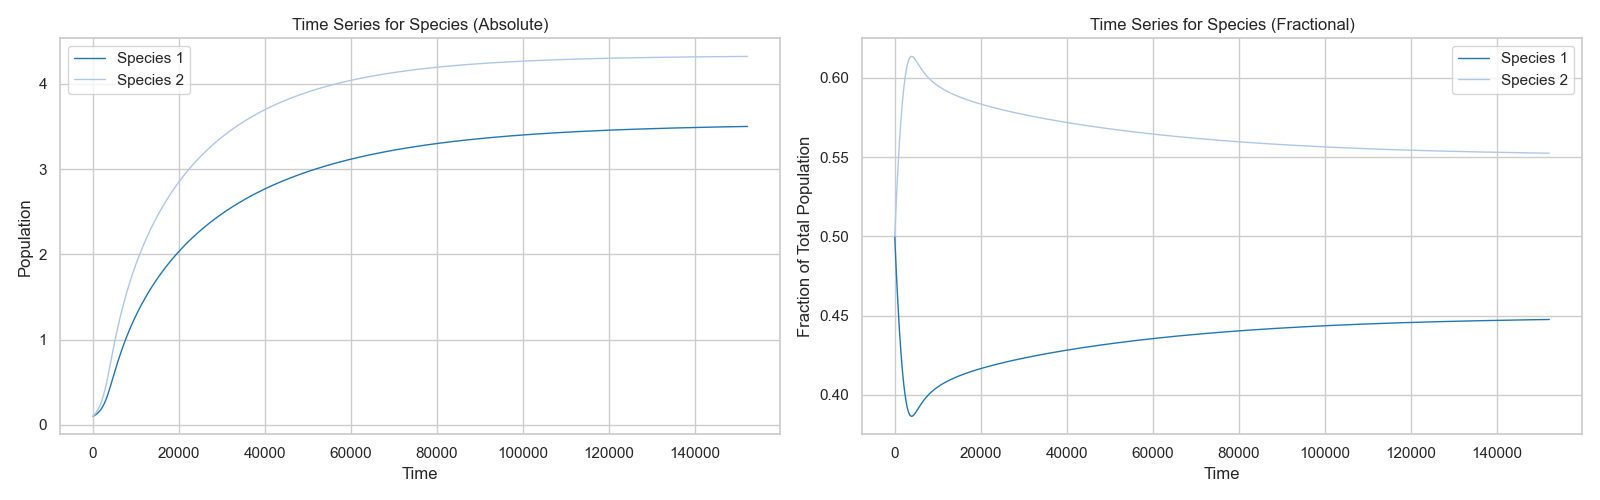

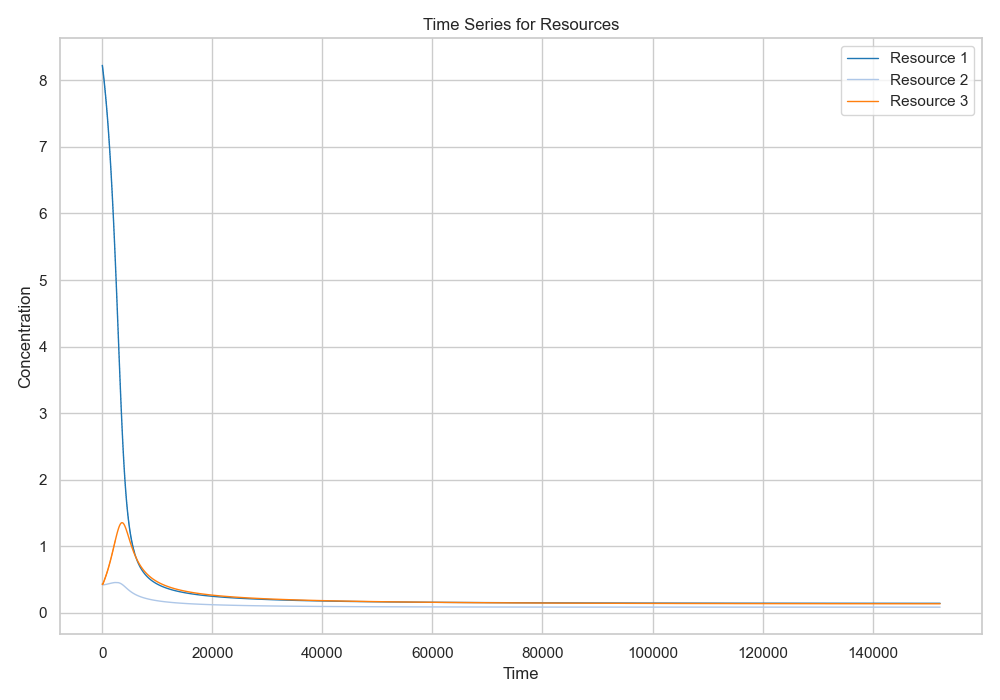

In [210]:
# wrapper for the visualization functions in shared/visualize.py file

def vis_wm_wrapper(N, R):
    """
    Wrapper function to display plots inline in a Jupyter notebook and then delete the files.
    """
    # Create a temporary directory
    with tempfile.TemporaryDirectory() as tmpdirname:
        # Call the original function
        visualize.vis_wm(N, R, tmpdirname)
        
        # Paths to the temporary plot files
        plot_path = os.path.join(tmpdirname, 'wmN.png')
        plot_path_R = os.path.join(tmpdirname, 'wmR.png')
        
        # Display the plots
        for plot in [plot_path, plot_path_R]:
            if os.path.exists(plot):
                img = Image.open(plot)
                display(img)

vis_wm_wrapper(N_fin,R_fin[1:])

In [222]:
# perform the mapping

gA = np.dot(gradA(R_fin[-1],param['l'][0],param['g'][0]),sigma(R_fin[-1],param['tau'][0],param['ext'][0]))
gB = np.dot(gradB(R_fin[-1],param['l'][0],param['g'][1]),sigma(R_fin[-1],param['tau'][0],param['ext'][0]))
aAB = np.dot(gradA(R_fin[-1],param['l'][0],param['g'][0]),fB(R_fin[-1],param['l'][0]))
aBA = np.dot(gradB(R_fin[-1],param['l'][0],param['g'][1]),fA(R_fin[-1],param['l'][0]))
aAA = np.dot(gradA(R_fin[-1],param['l'][0],param['g'][0]),fA(R_fin[-1],param['l'][0]))
aBB = np.dot(gradB(R_fin[-1],param['l'][0],param['g'][1]),fB(R_fin[-1],param['l'][0]))
print(gA,gB,aAB,aBA,aAA,aBB)

0.008964645236425827 0.011797003780203198 -0.00018060635438952363 0.0006238167824216267 -0.002343782224472607 -0.0032357540460663855


In [223]:
# simulate LV with these parameters

def LV_model(t,y,r0,A):

    sp_abund = y

    # Set abundances to zero if they are less than a threshold
    sp_abund[sp_abund < 1e-5] = 0

    dsdt = [sp_abund[alpha]*(r0[alpha] + np.dot(A[alpha,:],sp_abund)) for alpha in range(2)]
    
    return dsdt

In [227]:
# Solve Lotka-Volterra dynamics
lv_args = (np.array([gA,gB]),np.array([[aAA,aAB],[aBA,aBB]]))
t_span_lv = (0,1000)
t_eval_lv = np.arange(t_span_lv[0],t_span_lv[1],0.1)
solLV = solve_ivp(fun=LV_model, t_span=t_span_lv, y0=np.array([0.1,0.1]), t_eval=t_eval_lv, args=lv_args)

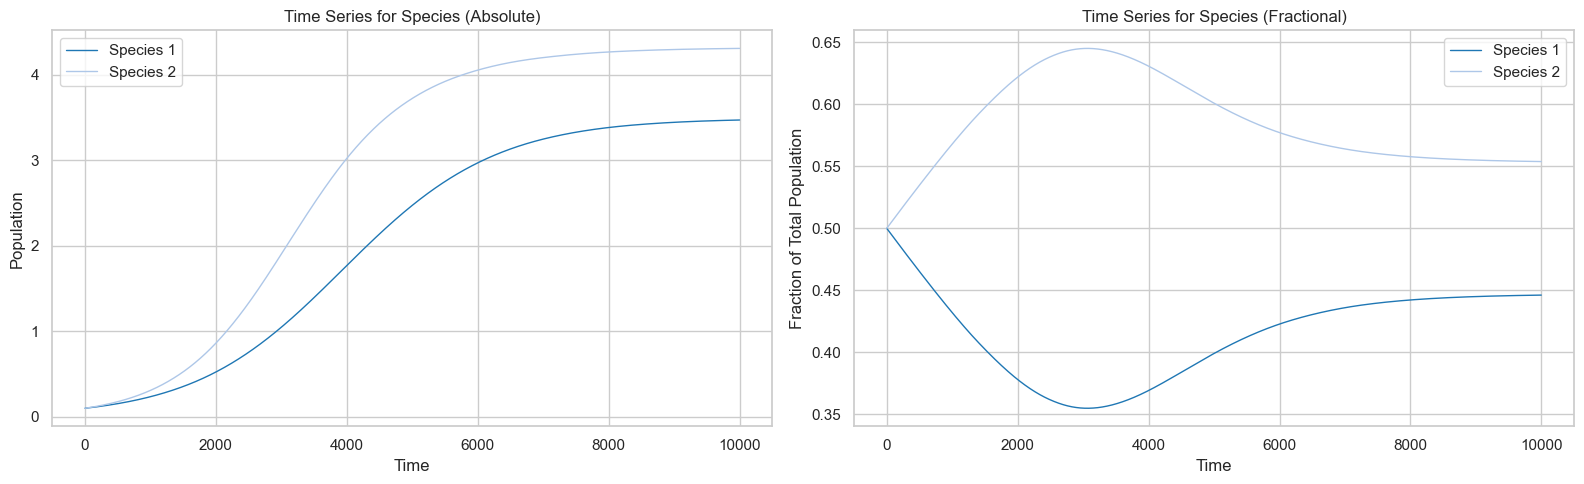

In [228]:

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Absolute abundances
axs[0].set_title("Time Series for Species (Absolute)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Population")

colors = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors)

for i in range(solLV.y.shape[0]):
    axs[0].plot(solLV.y[i,:], label=f'Species {i+1}', color=colors[i], linewidth=1)
axs[0].legend()
axs[0].grid(True)

# Fractional abundances
axs[1].set_title("Time Series for Species (Fractional)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Fraction of Total Population")

total_population = np.sum(solLV.y, axis=0, keepdims=True)
fractional_abundance = np.divide(solLV.y, total_population, where=total_population!=0)

for i in range(solLV.y.shape[0]):
    axs[1].plot(fractional_abundance[i,:], label=f'Species {i+1}', color=colors[i], linewidth=1)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()



In [229]:
print(fractional_abundance[:,-1])
print(solLV.y[:,-1])

[0.44617853 0.55382147]
[3.47159793 4.30913935]


### With modualtion on uptake

$\frac{dR_x}{dt}=\frac{R_x^0-R_x}{\tau}-s_A\frac{R_x}{1+R_x}\frac{R_z}{1+R_z}-s_B\frac{R_x}{1+R_x}\frac{R_y}{1+R_y}\\$
$\frac{dR_y}{dt}=\frac{-R_y}{\tau}-s_B\frac{R_y}{1+R_y}+s_A\frac{R_x}{1+R_x}\frac{R_z}{1+R_z}l\\$
$\frac{dR_z}{dt}=\frac{-R_z}{\tau}-s_A\frac{R_z}{1+R_z}+s_B\frac{R_x}{1+R_x}\frac{R_y}{1+R_y}l$

which transaltes in 

$\mathbf{f}_A=(-\frac{R_x}{1+R_x}\frac{R_z}{1+R_z},\frac{R_x}{1+R_x}\frac{R_z}{1+R_z}l,-\frac{R_z}{1+R_z})\\$
$\mathbf{f}_B=(-\frac{R_x}{1+R_x}\frac{R_y}{1+R_y},-\frac{R_y}{1+R_y},\frac{R_x}{1+R_x}\frac{R_y}{1+R_y}l)\\$
$\mathbf{\sigma}=(\frac{R_x^0-R_x}{\tau},\frac{-R_y}{\tau},\frac{-R_z}{\tau})$

for the sensitivity:

$\frac{1}{s_A}\frac{ds_A}{dt}=g_A^0(\frac{R_x}{1+R_x}(1-l)\frac{R_z}{1+R_z}-m_A)\\$
$\frac{1}{s_B}\frac{ds_B}{dt}=g_B^0(\frac{R_x}{1+R_x}(1-l)\frac{R_y}{1+R_y}-m_B)$

and the gradients:

$\nabla g_A=(g_A^0(1-l)\frac{R_z}{1+R_z}\frac{1}{(1+R_x)^2},0,g_A^0(1-l)\frac{R_x}{1+R_x}\frac{1}{(1+R_z)^2})\\$
$\nabla g_B=(g_B^0(1-l)\frac{R_y}{1+R_y}\frac{1}{(1+R_x)^2},g_B^0(1-l)\frac{R_x}{1+R_x}\frac{1}{(1+R_y)^2},0)$

In [324]:
# functions definition (assumes that R has 3 components)

def fA_mod(R,l):
    """
    R: array, 3 components, contains Rx,Ry and Rz
    l: int, leakage

    returns the impact vector of species A on the environment
    """
    fAx = -R[0]/(R[0]+1)*R[2]/(1+R[2])
    fAy = (R[0]/(R[0]+1))*R[2]/(1+R[2])*l
    fAz = -R[2]/(R[2]+1)

    return np.array([fAx,fAy,fAz])

def fB_mod(R,l):
    """
    R: array, 3 components, contains Rx,Ry and Rz
    l: int, leakage

    returns the impact vector of species A on the environment
    """
    fBx = -R[0]/(R[0]+1)*R[1]/(1+R[1])
    fBy = -R[1]/(R[1]+1)
    fBz = (R[0]/(R[0]+1))*R[1]/(1+R[1])*l

    return np.array([fBx,fBy,fBz])

In [380]:
# define the system 

# initialize R0
n_r = 3
n_s = 2

# drawing uptake matrix from binary distribution
# make matrices
up_mat   = np.array([[1,0.,1],[1,1,0.]])
met_mat  = np.array([[0.,0.,0.],[1.,0.,0.],[1,0.,0.]])
sign_mat = np.array([[1.,0.,0.],[1.,0.,0.]])
mat_ess  = np.array([[0.,0.,1.],[0.,1.,0.]])
spec_met = np.array([[0.,1,0.],[0.,0.,1]])

# totally symmetric g and m
m = np.ones((n_s))*0.01

# no reinsertion of produced chemicals
ext = np.zeros((n_r))
ext[0] = 20
dil = np.zeros((n_r))+100

g = np.array([0.5,1.])

# initial abundance and initial R guess
N0 =np.array([0.1,0.1])
guess = np.array([10,10,10])


# define parameters
param = {
    # model parameters
    'w'  : np.ones((n_r))*100,                          # energy conversion     [energy/mass]
    'l'  : np.ones((n_r))*0.8,                         # leakage               [adim]
    'g'  : g,                                          # growth conv. factors  [1/energy]
    'm'  : m,                                          # maintainance requ.    [energy/time]
    'ext': ext,                                        # external replenishment  
    'tau' : dil,                                       # chemicals dilution                             
    'tau_s': 10,                                        # species dilution
    'guess_wm': guess                                  # initial resources guess
}

# define matrices dict
mat = {
    'uptake'  : up_mat,
    'met'     : met_mat,
    'ess'     : mat_ess,
    'spec_met': spec_met,
    'sign'    : sign_mat
}

In [388]:
# run the model
N_fin_mod,R_fin_mod=well_mixed.run_wellmixed(N0,param,mat,well_mixed.dR_dt,well_mixed.dN_dt,2000000)

In [389]:
# final equilibrium
print(N_fin_mod[-1],R_fin_mod[-1])
print(N_fin_mod[-1]/np.sum(N_fin_mod[-1]))

[ 7.31140212 14.62370799] [1.85237169e+01 6.22022027e-04 1.24415606e-03]
[0.3333196 0.6666804]


In [ ]:
# simulate another 10000 steps

N_fin_mod2,R_fin_mod2=well_mixed.run_wellmixed(N_fin_mod[-1],param,mat,well_mixed.dR_dt,well_mixed.dN_dt,100000)

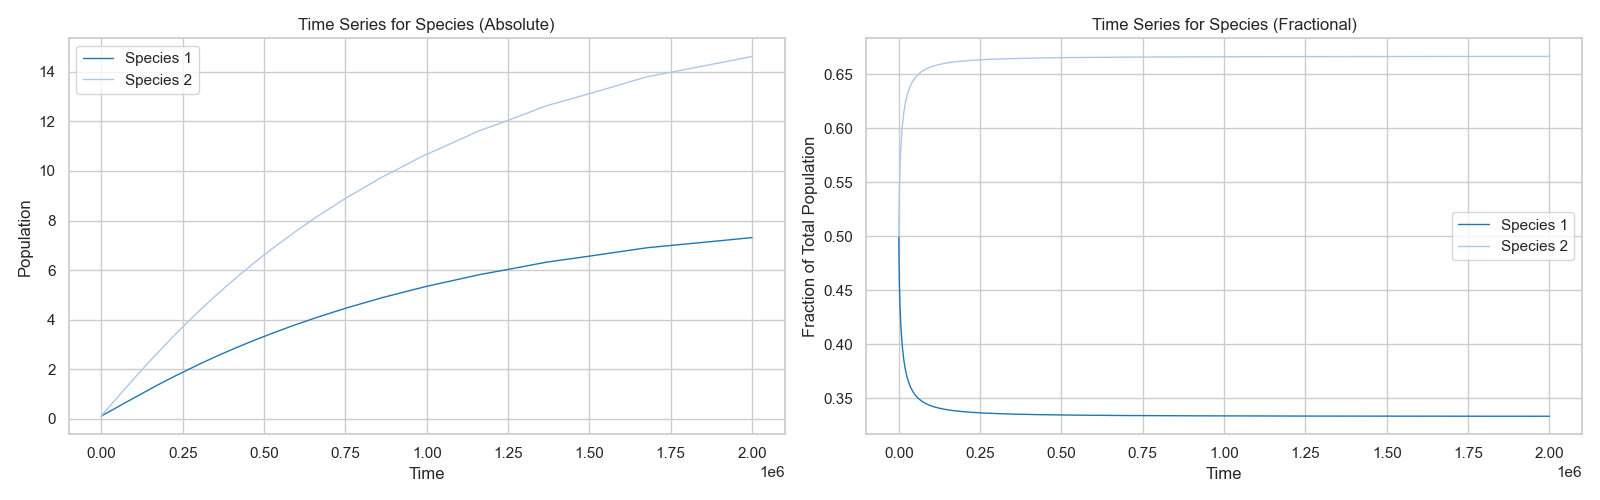

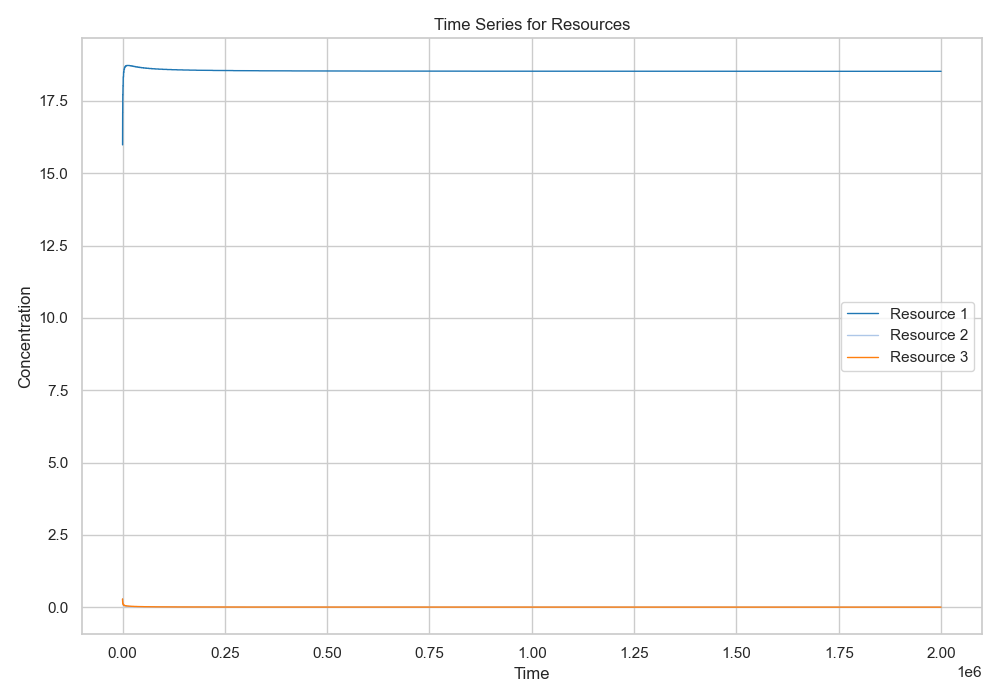

In [390]:
# wrapper for the visualization functions in shared/visualize.py file

def vis_wm_wrapper(N, R):
    """
    Wrapper function to display plots inline in a Jupyter notebook and then delete the files.
    """
    # Create a temporary directory
    with tempfile.TemporaryDirectory() as tmpdirname:
        # Call the original function
        visualize.vis_wm(N, R, tmpdirname)
        
        # Paths to the temporary plot files
        plot_path = os.path.join(tmpdirname, 'wmN.png')
        plot_path_R = os.path.join(tmpdirname, 'wmR.png')
        
        # Display the plots
        for plot in [plot_path, plot_path_R]:
            if os.path.exists(plot):
                img = Image.open(plot)
                display(img)

vis_wm_wrapper(N_fin_mod,R_fin_mod[1:])

In [391]:
# perform the mapping

gA_mod= np.dot(gradA(R_fin_mod[-1],param['l'][0],param['g'][0]),sigma(R_fin_mod[-1],param['tau'][0],param['ext'][0]))
gB_mod= np.dot(gradB(R_fin_mod[-1],param['l'][0],param['g'][1]),sigma(R_fin_mod[-1],param['tau'][0],param['ext'][0]))
aAB_mod = np.dot(gradA(R_fin_mod[-1],param['l'][0],param['g'][0]),fB_mod(R_fin_mod[-1],param['l'][0]))
aBA_mod = np.dot(gradB(R_fin_mod[-1],param['l'][0],param['g'][1]),fA_mod(R_fin_mod[-1],param['l'][0]))
aAA_mod = np.dot(gradA(R_fin_mod[-1],param['l'][0],param['g'][0]),fA_mod(R_fin_mod[-1],param['l'][0]))
aBB_mod = np.dot(gradB(R_fin_mod[-1],param['l'][0],param['g'][1]),fB_mod(R_fin_mod[-1],param['l'][0]))
print(gA_mod,gB_mod,aAB_mod,aBA_mod,aAA_mod,aBB_mod)

-1.1726862883217885e-06 -1.1740422603455506e-06 4.465551506994094e-05 0.00017874959531561342 -0.00011760395568844901 -0.00011781265204756018


In [397]:
# Solve Lotka-Volterra dynamics
lv_args = (np.array([gA_mod,gB_mod]),np.array([[aAA_mod,aAB_mod],[aBA_mod,aBB_mod]]))
t_span_lv = (0,1000000)
t_eval_lv = np.arange(t_span_lv[0],t_span_lv[1],0.1)
solLV = solve_ivp(fun=LV_model, t_span=t_span_lv, y0=np.array([0.1,0.1]), t_eval=t_eval_lv, args=lv_args)

In [398]:
solLV.y[:,-1]/np.sum(solLV.y[:,-1])

array([0.35428817, 0.64571183])

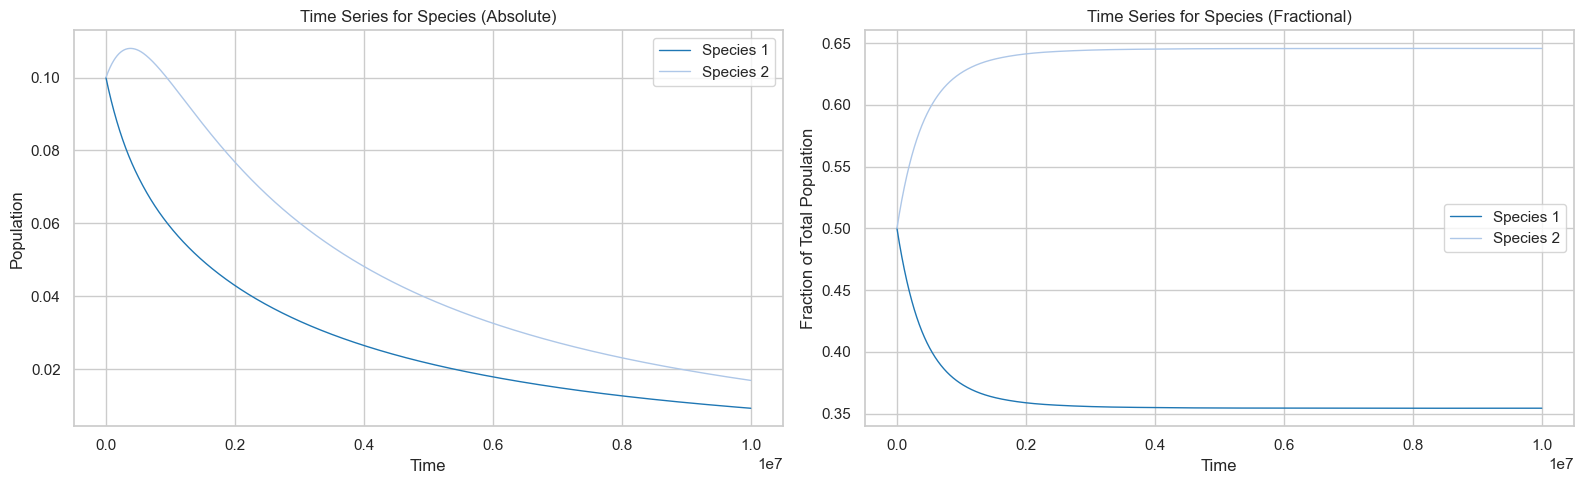

In [399]:

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Absolute abundances
axs[0].set_title("Time Series for Species (Absolute)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Population")

colors = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors)

for i in range(solLV.y.shape[0]):
    axs[0].plot(solLV.y[i,:], label=f'Species {i+1}', color=colors[i], linewidth=1)
axs[0].legend()
axs[0].grid(True)

# Fractional abundances
axs[1].set_title("Time Series for Species (Fractional)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Fraction of Total Population")

total_population = np.sum(solLV.y, axis=0, keepdims=True)
fractional_abundance = np.divide(solLV.y, total_population, where=total_population!=0)

for i in range(solLV.y.shape[0]):
    axs[1].plot(fractional_abundance[i,:], label=f'Species {i+1}', color=colors[i], linewidth=1)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()



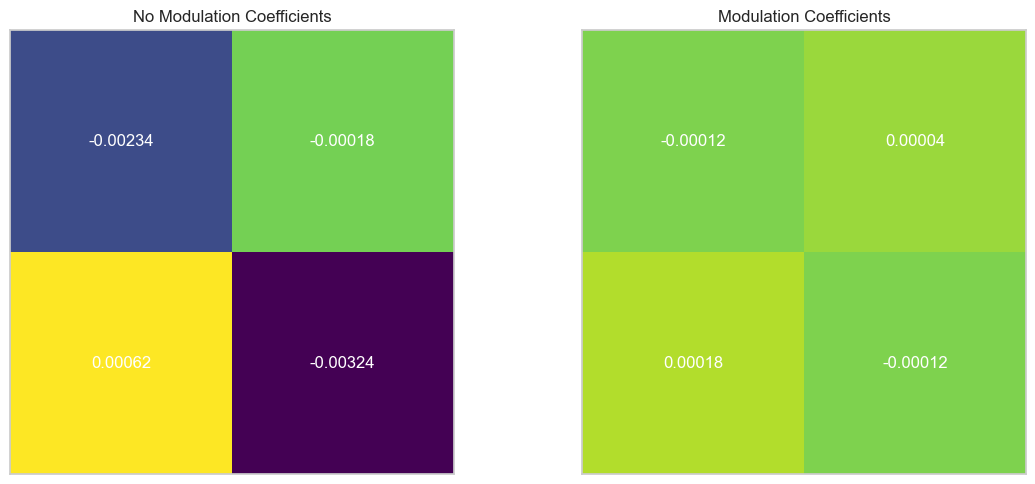

In [396]:
# Example matrices
matrix1 = np.array([[aAA_mod, aAB_mod], [aBA_mod, aBB_mod]])
matrix2 = np.array([[aAA, aAB], [aBA, aBB]])

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Find the global min and max to ensure both matrices share the same color scale
vmin = min(matrix1.min(), matrix2.min())
vmax = max(matrix1.max(), matrix2.max())

# Plot the second matrix (swapped position) with shared vmin and vmax
im1 = axes[0].imshow(matrix2, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title('No Modulation Coefficients')

# Annotate the second heatmap with the numerical values rounded to the 5th decimal place
for i in range(matrix2.shape[0]):
    for j in range(matrix2.shape[1]):
        text = axes[0].text(j, i, f"{matrix2[i, j]:.5f}",
                            ha="center", va="center", color="white")

# Plot the first matrix (swapped position) with shared vmin and vmax
im2 = axes[1].imshow(matrix1, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title('Modulation Coefficients')

# Annotate the first heatmap with the numerical values rounded to the 5th decimal place
for i in range(matrix1.shape[0]):
    for j in range(matrix1.shape[1]):
        text = axes[1].text(j, i, f"{matrix1[i, j]:.5f}",
                            ha="center", va="center", color="white")


# Remove grid lines
for ax in axes:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()